### Imports

In [1]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
from mplsoccer import Sbopen

## Collecting Data

In [3]:
parser = Sbopen()
df_match = parser.match(competition_id=43, season_id=106)

## Collecting Shots

In [4]:
# iterate through all matches to get the events data
df_matches = {}
for i, id in enumerate(df_match['match_id']):
  df_matches[id] = {}
  df_matches[id]['event'], df_matches[id]['related'], df_matches[id]['freeze'], df_matches[id]['tactic'] = parser.event(id)

## Preparing Data

In [5]:
new_features = ['x', 'y', 'outcome_name', 'sub_type_name', 'body_part_name', 'under_pressure', 'technique_name', 'shot_statsbomb_xg']
df_shot = pd.DataFrame(columns=new_features)

for id in df_match['match_id']:
  mask_shot = (df_matches[id]['event'].type_name == 'Shot') & (df_matches[id]['event'].period	<= 4)
  shots_temp = df_matches[id]['event'].loc[mask_shot, new_features]
  df_shot = pd.concat([df_shot, shots_temp]).reset_index(drop=True)

<ipython-input-5-52d248324fd8>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_shot = pd.concat([df_shot, shots_temp]).reset_index(drop=True)


In [6]:
df_shot.head()

x     y outcome_name sub_type_name body_part_name  under_pressure  \
0   96.0  38.8      Blocked     Open Play      Left Foot             NaN   
1  113.1  40.7        Saved     Open Play      Left Foot             NaN   
2  103.8  41.9        Saved     Open Play     Right Foot             NaN   
3  112.2  36.8        Off T     Open Play           Head             NaN   
4   97.8  51.5         Post     Open Play      Left Foot             NaN   

  technique_name  shot_statsbomb_xg  
0    Half Volley           0.036566  
1    Half Volley           0.353289  
2    Half Volley           0.069527  
3         Normal           0.081609  
4         Normal           0.030002

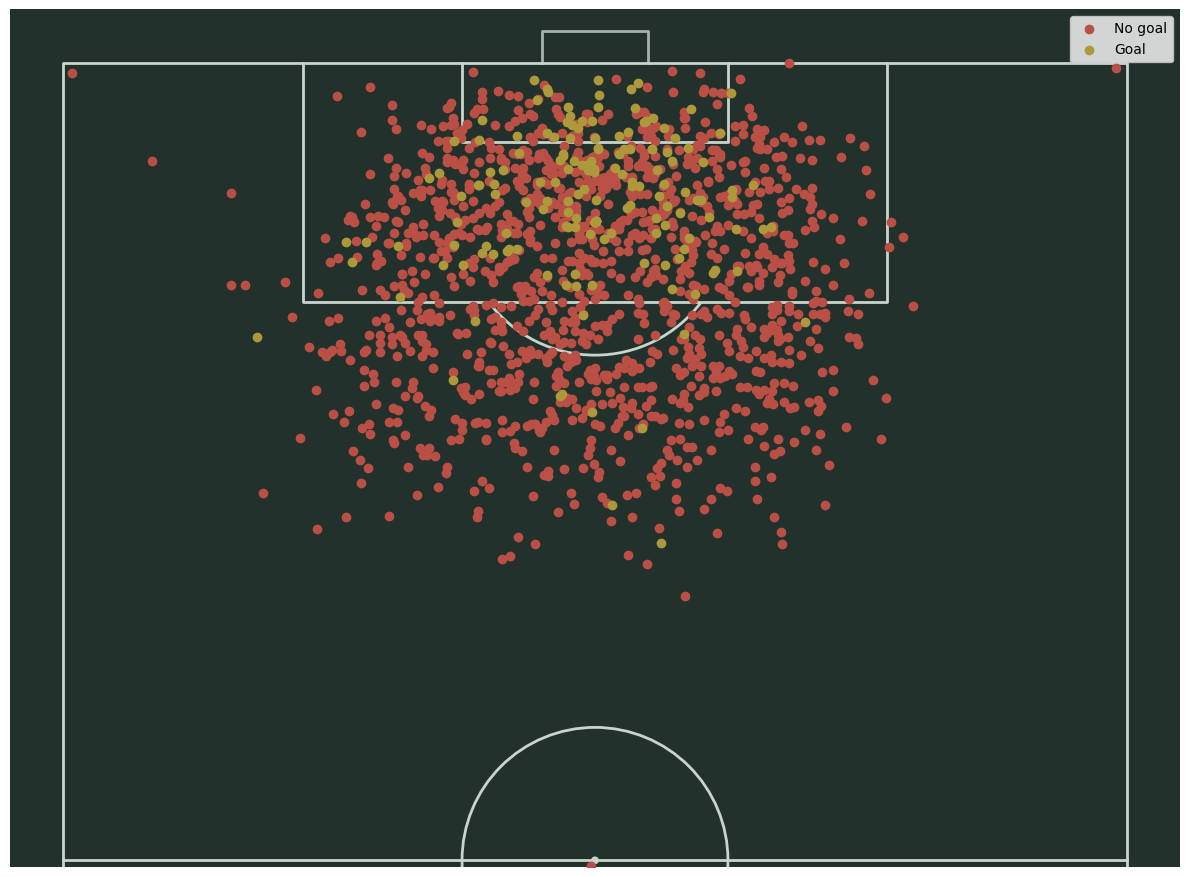

In [7]:
# visualizing shots

# filter goals / non-shot goals
df_goals = df_shot[df_shot.outcome_name == 'Goal'].copy()
df_non_goal_shots = df_shot[df_shot.outcome_name != 'Goal'].copy()

# setup the pitch
pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8, pitch_color='#22312b', line_color='#c7d5cc')  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

sc1 = pitch.scatter(df_non_goal_shots.x, df_non_goal_shots.y,
                    c='#ba4f45',
                    marker='o',
                    ax=ax, label="No goal")

sc2 = pitch.scatter(df_goals.x, df_goals.y,
                    c='#ad993c',
                    marker='o',
                    ax=ax, label="Goal")

plt.legend(loc='best')
plt.show()

In [8]:
df_shot.body_part_name.unique()

array(['Left Foot', 'Right Foot', 'Head', 'Other'], dtype=object)

In [9]:
import math

def calculate_angle(x, y):
  # 44 and 36 is the location of each goal post
  g0 = [120, 44]
  p = [x, y]
  g1 = [120, 36]

  v0 = np.array(g0) - np.array(p)
  v1 = np.array(g1) - np.array(p)

  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
  return(abs(np.degrees(angle)))

def calculate_distance(x, y):
  x_dist = 120-x
  y_dist = 0
  if (y<36):
    y_dist = 36-y
  elif (y>44):
    y_dist = y-44
  return math.sqrt(x_dist**2 + y_dist**2)

In [10]:
df_shot['angle'] = df_shot.apply(lambda row:calculate_angle(row['x'], row['y']), axis=1)
df_shot['distance'] = df_shot.apply(lambda row:calculate_distance(row['x'], row['y']), axis=1)

<ipython-input-9-c91f0c7ae35d>:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))


In [11]:
df_shot['header'] = df_shot.apply(lambda row:1 if row['body_part_name']=='Head' else 0, axis=1)

In [12]:
df_shot['under_pressure'] = df_shot['under_pressure'].fillna(0)
df_shot['under_pressure'] = df_shot['under_pressure'].astype(int)

In [13]:
df_shot.head()

x     y outcome_name sub_type_name body_part_name  under_pressure  \
0   96.0  38.8      Blocked     Open Play      Left Foot               0   
1  113.1  40.7        Saved     Open Play      Left Foot               0   
2  103.8  41.9        Saved     Open Play     Right Foot               0   
3  112.2  36.8        Off T     Open Play           Head               0   
4   97.8  51.5         Post     Open Play      Left Foot               0   

  technique_name  shot_statsbomb_xg      angle  distance  header  
0    Half Volley           0.036566  18.879548  24.00000       0  
1    Half Volley           0.353289  59.821068   6.90000       0  
2    Half Volley           0.069527  27.397542  16.20000       0  
3         Normal           0.081609  48.565404   7.80000       1  
4         Normal           0.030002  16.255762  23.43267       0

In [14]:
df_shot.technique_name.unique()

array(['Half Volley', 'Normal', 'Volley', 'Backheel', 'Diving Header',
       'Lob', 'Overhead Kick'], dtype=object)

In [15]:
df_shot.sub_type_name.unique()

array(['Open Play', 'Corner', 'Free Kick', 'Penalty'], dtype=object)

In [16]:
# one hot encoding for techniques and sub types
df_shot = pd.get_dummies(df_shot, columns = ['technique_name'])
df_shot = pd.get_dummies(df_shot, columns = ['sub_type_name'])

In [17]:
df_shot['goal'] = df_shot.apply(lambda row:1 if row['outcome_name']=='Goal' else 0, axis=1)

In [18]:
df_shot.head()

x     y outcome_name body_part_name  under_pressure  shot_statsbomb_xg  \
0   96.0  38.8      Blocked      Left Foot               0           0.036566   
1  113.1  40.7        Saved      Left Foot               0           0.353289   
2  103.8  41.9        Saved     Right Foot               0           0.069527   
3  112.2  36.8        Off T           Head               0           0.081609   
4   97.8  51.5         Post      Left Foot               0           0.030002   

       angle  distance  header  technique_name_Backheel  ...  \
0  18.879548  24.00000       0                    False  ...   
1  59.821068   6.90000       0                    False  ...   
2  27.397542  16.20000       0                    False  ...   
3  48.565404   7.80000       1                    False  ...   
4  16.255762  23.43267       0                    False  ...   

   technique_name_Half Volley  technique_name_Lob  technique_name_Normal  \
0                        True               False                  False   
1                        True               False                  False   
2                        True               False                  False   
3                       False               False                   True   
4                       False               False                   True   

   technique_name_Overhead Kick  technique_name_Volley  sub_type_name_Corner  \
0                         False                  False                 False   
1                         False                  False                 False   
2                         False                  False                 False   
3                         False                  False                 False   
4                         False                  False                 False   

   sub_type_name_Free Kick  sub_type_name_Open Play  sub_type_name_Penalty  \
0                    False                     True                  False   
1                    False                     True                  False   
2                    False                     True                  False   
3                    False                     True                  False   
4                    False                     True                  False   

   goal  
0     0  
1     0  
2     0  
3     0  
4     0  

[5 rows x 21 columns]

In [19]:
df_shot.columns

Index(['x', 'y', 'outcome_name', 'body_part_name', 'under_pressure',
       'shot_statsbomb_xg', 'angle', 'distance', 'header',
       'technique_name_Backheel', 'technique_name_Diving Header',
       'technique_name_Half Volley', 'technique_name_Lob',
       'technique_name_Normal', 'technique_name_Overhead Kick',
       'technique_name_Volley', 'sub_type_name_Corner',
       'sub_type_name_Free Kick', 'sub_type_name_Open Play',
       'sub_type_name_Penalty', 'goal'],
      dtype='object')

## Modeling
From the charts above, you can see the regression line between goal and the features, and it's confirmed that the wider the angle the more likely a shot become a goal, the closer the distance the more likely it become a goal

Now let's build our model using Linear Regression and also Logistic Regression, I'll explain why we can't use the Linear Regression model later

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

model_names = ['Linear', 'Logistic']
models = {}
models['Linear'] = {}
models['Linear']['model'] = LinearRegression()
models['Logistic'] = {}
models['Logistic']['model'] = LogisticRegression()

In [21]:
X = df_shot[['angle', 'distance']]
y = df_shot['goal']

In [22]:
from sklearn import metrics
for mod in model_names:
  models[mod]['model'].fit(X, y)
  if mod == 'Logistic':
    models[mod]['y_pred'] = models[mod]['model'].predict_proba(X)[:, 1]
  else:
    models[mod]['y_pred'] = models[mod]['model'].predict(X)

  models[mod]['r2_score'] = metrics.r2_score(y, models[mod]['y_pred'])
  print("R2 of model {}: {}".format(mod, models[mod]['r2_score']))

R2 of model Linear: 0.10226490043852554
R2 of model Logistic: 0.09361130106060134


In [23]:
# let's see the R2 Score of the Statsbomb xG model
metrics.r2_score(y, df_shot['shot_statsbomb_xg'])

0.24044871027283854

- Obviously our model doesn't perform any better than the advanced Statsbomb xG model since we only use 2 features and relatively small number of samples

In [24]:
df_shot['xG_Linear'] = models['Linear']['y_pred']
df_shot['xG_Logistic'] = models['Logistic']['y_pred']

In [25]:
df_shot.head()

x     y outcome_name body_part_name  under_pressure  shot_statsbomb_xg  \
0   96.0  38.8      Blocked      Left Foot               0           0.036566   
1  113.1  40.7        Saved      Left Foot               0           0.353289   
2  103.8  41.9        Saved     Right Foot               0           0.069527   
3  112.2  36.8        Off T           Head               0           0.081609   
4   97.8  51.5         Post      Left Foot               0           0.030002   

       angle  distance  header  technique_name_Backheel  ...  \
0  18.879548  24.00000       0                    False  ...   
1  59.821068   6.90000       0                    False  ...   
2  27.397542  16.20000       0                    False  ...   
3  48.565404   7.80000       1                    False  ...   
4  16.255762  23.43267       0                    False  ...   

   technique_name_Normal  technique_name_Overhead Kick  technique_name_Volley  \
0                  False                         False                  False   
1                  False                         False                  False   
2                  False                         False                  False   
3                   True                         False                  False   
4                   True                         False                  False   

   sub_type_name_Corner  sub_type_name_Free Kick  sub_type_name_Open Play  \
0                 False                    False                     True   
1                 False                    False                     True   
2                 False                    False                     True   
3                 False                    False                     True   
4                 False                    False                     True   

   sub_type_name_Penalty  goal  xG_Linear  xG_Logistic  
0                  False     0   0.060109     0.046136  
1                  False     0   0.324018     0.320059  
2                  False     0   0.124931     0.095060  
3                  False     0   0.260349     0.248185  
4                  False     0   0.047083     0.044946  

[5 rows x 23 columns]

### Linear Regression Model

In [26]:
df_shot.loc[df_shot['xG_Linear'] < 0]

x     y outcome_name body_part_name  under_pressure  \
67    119.2   0.7        Saved     Right Foot               0   
69     84.3  34.2        Saved     Right Foot               0   
164    89.7  57.6        Off T     Right Foot               0   
239    84.6  49.2      Blocked      Left Foot               0   
273   119.6  79.2        Saved      Left Foot               0   
299   118.2  23.1        Saved      Left Foot               1   
306    83.0  42.5        Off T     Right Foot               0   
426    87.5  26.6        Off T     Right Foot               0   
448    82.3  43.9        Saved      Left Foot               0   
449    85.8  21.3        Off T      Left Foot               0   
539   110.2  12.6        Saved     Right Foot               0   
546    79.9  46.8        Off T     Right Foot               0   
549    59.6  39.7        Off T     Right Foot               0   
588    82.7  33.0        Saved     Right Foot               0   
679    99.4  14.6         Goal     Right Foot               0   
680    84.9  19.1      Wayward     Right Foot               1   
736   103.3  13.7        Saved     Right Foot               0   
763   112.6   6.7        Off T     Right Foot               0   
829    88.4  22.4        Off T      Left Foot               0   
831    91.7  61.5        Off T     Right Foot               0   
849    89.5  22.9        Off T     Right Foot               0   
871    86.7  57.3      Blocked      Left Foot               0   
904    83.8  54.1      Blocked      Left Foot               0   
924   103.3  12.6        Off T     Right Foot               0   
933    85.9  24.5      Blocked     Right Foot               0   
991    59.0   4.0        Off T     Right Foot               0   
1078   84.7  54.0        Saved     Right Foot               0   
1128   91.8  17.8        Off T     Right Foot               0   
1182   90.8  21.8        Off T     Right Foot               0   
1188   82.9  33.6        Off T      Left Foot               0   
1200   83.9  45.0         Goal      Left Foot               0   
1225   87.6  15.0        Saved     Right Foot               0   
1261   85.8  53.5      Blocked     Right Foot               0   
1302   83.8  35.5        Off T     Right Foot               0   
1362  117.5  20.6        Saved     Right Foot               0   
1388  120.0  54.6        Off T           Head               1   
1399   90.1  22.3        Saved     Right Foot               0   
1426   94.8  61.9        Saved      Left Foot               0   

      shot_statsbomb_xg      angle   distance  header  \
67             0.000180   0.239804  35.309064       0   
69             0.007537  12.463718  35.745349       0   
164            0.007071  11.311296  33.212197       0   
239            0.006639  12.092981  35.779883       0   
273            0.000180   0.120559  35.202273       0   
299            0.010853   3.021054  13.024976       0   
306            0.006952  12.285335  37.000000       0   
426            0.006506  12.032415  33.832085       0   
448            0.007521  11.987010  37.700000       0   
449            0.005868  10.314707  37.225395       0   
539            0.007358   5.390859  25.369273       0   
546            0.005648  11.079392  40.197637       0   
549            0.004195   7.577594  60.400000       0   
588            0.005822  11.832772  37.420449       0   
679            0.007769   8.890613  29.703872       0   
680            0.007159   9.642001  38.956643       0   
736            0.007010   7.967185  27.860007       0   
763            0.007375   2.952909  30.220026       0   
829            0.006217  11.068272  34.402326       0   
831            0.006610  10.289159  33.273713       0   
849            0.006098  11.431693  33.194277       0   
871            0.015201  10.832855  35.857775       0   
904            0.005484  10.975655  37.582576       0   
924            0.006376   7.508359  28.748043       0   
933            0.005914  11.126634  35.986942    

In [27]:
import altair as alt

fig = alt.Chart(df_shot).mark_point().encode(
  x='angle',y='xG_Linear')
fig

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [28]:
import altair as alt

fig = alt.Chart(df_shot).mark_point().encode(
  x='distance',y='xG_Linear')
fig

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Why we can't use Linear Regression model
- Linear Regression model works on a line, which means on certain point it will reach negative values
- And you can see there are some negative xG predicted, which doesn't make any sense since there is no such thing as negative probability
- Probability of something happening is between 0 and 1, so we can't use this Linear Regression model

### Logistic Regression Model

In [29]:
df_shot.loc[df_shot['xG_Logistic'] < 0]

Empty DataFrame
Columns: [x, y, outcome_name, body_part_name, under_pressure, shot_statsbomb_xg, angle, distance, header, technique_name_Backheel, technique_name_Diving Header, technique_name_Half Volley, technique_name_Lob, technique_name_Normal, technique_name_Overhead Kick, technique_name_Volley, sub_type_name_Corner, sub_type_name_Free Kick, sub_type_name_Open Play, sub_type_name_Penalty, goal, xG_Linear, xG_Logistic]
Index: []

[0 rows x 23 columns]

- There's no negative xG predicted

In [30]:
import altair as alt

fig = alt.Chart(df_shot).mark_point().encode(
  x='angle',y='xG_Logistic')
fig

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [31]:
import altair as alt

fig = alt.Chart(df_shot).mark_point().encode(
  x='distance',y='xG_Logistic')
fig

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [33]:
X_cols = ['under_pressure', 'angle', 'distance',
      'header', 'technique_name_Backheel',
       'technique_name_Diving Header', 'technique_name_Half Volley',
       'technique_name_Lob', 'technique_name_Normal',
       'technique_name_Overhead Kick', 'technique_name_Volley',
       'sub_type_name_Corner', 'sub_type_name_Free Kick',
       'sub_type_name_Open Play', 'sub_type_name_Penalty']
X = df_shot[X_cols]
X.head()

under_pressure      angle  distance  header  technique_name_Backheel  \
0               0  18.879548  24.00000       0                    False   
1               0  59.821068   6.90000       0                    False   
2               0  27.397542  16.20000       0                    False   
3               0  48.565404   7.80000       1                    False   
4               0  16.255762  23.43267       0                    False   

   technique_name_Diving Header  technique_name_Half Volley  \
0                         False                        True   
1                         False                        True   
2                         False                        True   
3                         False                       False   
4                         False                       False   

   technique_name_Lob  technique_name_Normal  technique_name_Overhead Kick  \
0               False                  False                         False   
1               False                  False                         False   
2               False                  False                         False   
3               False                   True                         False   
4               False                   True                         False   

   technique_name_Volley  sub_type_name_Corner  sub_type_name_Free Kick  \
0                  False                 False                    False   
1                  False                 False                    False   
2                  False                 False                    False   
3                  False                 False                    False   
4                  False                 False                    False   

   sub_type_name_Open Play  sub_type_name_Penalty  
0                     True                  False  
1                     True                  False  
2                     True                  False  
3                     True                  False  
4                     True                  False

In [34]:
y = df_shot['goal']

In [35]:
X.shape

(1453, 15)

In [36]:
adv_model = LogisticRegression()
adv_model.fit(X, y)
y_pred = adv_model.predict_proba(X)[:, 1]
metrics.r2_score(y, y_pred)

0.18787241041649483

## Evaluate on all matches

In [37]:
X.columns

Index(['under_pressure', 'angle', 'distance', 'header',
       'technique_name_Backheel', 'technique_name_Diving Header',
       'technique_name_Half Volley', 'technique_name_Lob',
       'technique_name_Normal', 'technique_name_Overhead Kick',
       'technique_name_Volley', 'sub_type_name_Corner',
       'sub_type_name_Free Kick', 'sub_type_name_Open Play',
       'sub_type_name_Penalty'],
      dtype='object')

In [40]:
# define function to calculate xG
def calculate_xg_adv(row):
  under_pressure = 0 if np.isnan(row['under_pressure']) else 1
  angle = calculate_angle(row['x'], row['y'])
  distance = calculate_distance(row['x'], row['y'])
  header = 1 if row['body_part_name']=='Head' else 0
  technique_name = {}
  sub_type_name = {}
  technique_name['Backheel'] = technique_name['Diving Header'] = 0
  technique_name['Half Volley'] = technique_name['Lob'] = 0
  technique_name['Normal'] = technique_name['Overhead Kick'] = 0
  technique_name['Volley'] = sub_type_name['Corner'] = 0
  sub_type_name['Free Kick'] = sub_type_name['Open Play'] = 0
  sub_type_name['Penalty'] = 0
  technique_name[row['technique_name']] = 1
  sub_type_name[row['sub_type_name']] = 1
  X = [[under_pressure, angle, distance, header,
        technique_name['Backheel'], technique_name['Diving Header'],
        technique_name['Half Volley'], technique_name['Lob'],
        technique_name['Normal'], technique_name['Overhead Kick'],
        technique_name['Volley'], sub_type_name['Corner'],
        sub_type_name['Free Kick'], sub_type_name['Open Play'],
        sub_type_name['Penalty']]]
  xg = adv_model.predict_proba(X)[:, 1][0]
  return xg

In [41]:
# let's try to evaluate it on all matches and store it into dataframe
df_summary = df_match[['match_id', 'home_team_name', 'away_team_name']].copy()

home_goal = []
home_xg = []
home_xg_sb = []

away_goal = []
away_xg = []
away_xg_sb = []

for i, id in enumerate(df_match.match_id):
  df_evaluate = df_matches[id]['event'][df_matches[id]['event']['type_name'] == 'Shot']

  # take only open play
  evaluate_mask = (df_evaluate.type_name == 'Shot') & (df_evaluate.period	<= 4)
  df_evaluate = df_evaluate[evaluate_mask]

  # calculate xg per shot
  df_evaluate['our_xg'] = df_evaluate.apply(lambda row:calculate_xg_adv(row), axis=1)

  # home team
  df_home = df_evaluate[df_evaluate.team_name == df_match['home_team_name'][i]]
  home_goal.append(len(df_home[df_home.outcome_name == 'Goal']))
  home_xg.append(df_home.our_xg.sum())
  home_xg_sb.append(df_home.shot_statsbomb_xg.sum())

  # away team
  df_away = df_evaluate[df_evaluate.team_name == df_match['away_team_name'][i]]
  away_goal.append(len(df_away[df_away.outcome_name == 'Goal']))
  away_xg.append(df_away.our_xg.sum())
  away_xg_sb.append(df_away.shot_statsbomb_xg.sum())

df_summary['home_goal'] = home_goal
df_summary['home_xg'] = home_xg
df_summary['home_xg_sb'] = home_xg_sb

df_summary['away_goal'] = away_goal
df_summary['away_xg'] = away_xg
df_summary['away_xg_sb'] = away_xg_sb

<ipython-input-9-c91f0c7ae35d>:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
<ipython-input-9-c91f0c7ae35d>:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
<ipython-input-9-c91f0c7ae35d>:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
<ipython-input-9-c91f0c7ae35d>:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.

In [42]:
df_summary.head(10)

match_id home_team_name away_team_name  home_goal   home_xg  home_xg_sb  \
0   3857256         Serbia    Switzerland          2  1.504341    1.189004   
1   3869151      Argentina      Australia          2  1.357302    1.481579   
2   3857257      Australia        Denmark          1  0.414827    0.469723   
3   3857258         Brazil         Serbia          2  1.945171    2.123890   
4   3857288        Tunisia      Australia          0  1.324778    1.052170   
5   3857267        Ecuador        Senegal          1  1.087237    1.001663   
6   3869321    Netherlands      Argentina          2  0.719272    0.569538   
7   3857287        Uruguay    South Korea          0  0.636762    0.417294   
8   3869486        Morocco       Portugal          1  0.873009    0.972023   
9   3869685      Argentina         France          3  2.809636    2.758306   

   away_goal   away_xg  away_xg_sb  
0          3  2.440016    3.103515  
1          0  0.582178    0.426118  
2          0  1.294226    0.737155  
3          0  0.211936    0.163327  
4          1  0.475485    0.359038  
5          2  1.764113    1.707465  
6          2  1.635272    1.939197  
7          0  0.632533    0.492993  
8          0  0.832630    0.744121  
9          3  1.902692    2.272618

In [43]:
df_summary.describe()

match_id  home_goal    home_xg  home_xg_sb  away_goal    away_xg  \
count  6.400000e+01  64.000000  64.000000   64.000000  64.000000  64.000000   
mean   3.860294e+06   1.546875   1.327491    1.248852   1.093750   1.313373   
std    5.267132e+03   1.562758   0.789941    0.798603   1.064861   0.843778   
min    3.857254e+06   0.000000   0.113378    0.104464   0.000000   0.000000   
25%    3.857270e+06   0.000000   0.717974    0.628575   0.000000   0.805810   
50%    3.857286e+06   1.000000   1.231641    1.060574   1.000000   1.203648   
75%    3.860255e+06   2.000000   1.831870    1.766720   2.000000   1.618748   
max    3.869685e+06   7.000000   3.353190    3.261424   4.000000   4.156559   

       away_xg_sb  
count   64.000000  
mean     1.187063  
std      0.854806  
min      0.000000  
25%      0.494491  
50%      1.025696  
75%      1.640182  
max      4.316106